<a href="https://colab.research.google.com/github/Nakib-Nasrullah/Code-With-Harry-Python/blob/main/final_predef.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install wfdb==4.3.0
import wfdb

In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
# Download dataset
DATA_DIR = "mitdb"
if not os.path.exists(DATA_DIR):
    wfdb.dl_database('mitdb', dl_dir=DATA_DIR)

In [ ]:
#Parameters
WINDOW = 187
HALF = WINDOW // 2

label_map = {
    'N': 0, 'L': 0, 'R': 0, 'e': 0, 'j': 0,
    'A': 1, 'a': 1, 'J': 1, 'S': 1,
    'V': 2, 'E': 2,
    'F': 3
}

beats = []

records = sorted([f.split('.')[0] for f in os.listdir(DATA_DIR) if f.endswith('.dat')])

for record in records:
    try:
        signal, _ = wfdb.rdsamp(os.path.join(DATA_DIR, record))
        ann = wfdb.rdann(os.path.join(DATA_DIR, record), 'atr')
    except:
        continue

    ecg = signal[:, 0]
    for r, sym in zip(ann.sample, ann.symbol):
        if sym not in label_map:
            continue
        if r - HALF < 0 or r + HALF >= len(ecg):
            continue
        beat = ecg[r-HALF:r+HALF+1]
        if len(beat) == WINDOW:
            beats.append([record] + beat.tolist() + [label_map[sym]])

columns = ["record_id"] + [f"f{i}" for i in range(WINDOW)] + ["label"]
df = pd.DataFrame(beats, columns=columns)
df.to_csv("mitbih_patient_level.csv", index=False)

print(" mitbih_patient_level.csv created")

 mitbih_patient_level.csv created


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.read_csv("mitbih_patient_level.csv")

patients = df['record_id'].unique()

train_patients, test_patients = train_test_split(
    patients, test_size=0.25, random_state=20
)

train_df = df[df['record_id'].isin(train_patients)]
test_df  = df[df['record_id'].isin(test_patients)]

assert set(train_df['record_id']).isdisjoint(set(test_df['record_id']))

train_df.to_csv("mitbih_train_patient.csv", index=False)
test_df.to_csv("mitbih_test_patient.csv", index=False)

print(" Patient-independent split saved")

 Patient-independent split saved


In [ ]:
import numpy as np
import pandas as pd

train_df = pd.read_csv("mitbih_train_patient.csv")
test_df  = pd.read_csv("mitbih_test_patient.csv")

print(train_df.shape, test_df.shape)

(79368, 189) (22058, 189)


In [ ]:
X_train = train_df.iloc[:, 1:-1].values
y_train = train_df['label'].values.astype(int)

X_test = test_df.iloc[:, 1:-1].values
y_test = test_df['label'].values.astype(int)

# Per-beat normalization
X_train = (X_train - X_train.mean(axis=1, keepdims=True)) / (X_train.std(axis=1, keepdims=True) + 1e-8)
X_test  = (X_test  - X_test.mean(axis=1, keepdims=True))  / (X_test.std(axis=1, keepdims=True)  + 1e-8)

X_train = X_train.reshape(-1, 187, 1)
X_test  = X_test.reshape(-1, 187, 1)

print("CNN input:", X_train.shape)

CNN input: (79368, 187, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv1D(32, 5, activation='relu', input_shape=(187, 1)),
    BatchNormalization(),
    MaxPooling1D(2),

    Conv1D(64, 5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),

    Conv1D(128, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(
    optimizer=Adam(0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 183, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 183, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 91, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 87, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 87, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 43, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 41, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 41, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 364,420 (1.39 MB)

 Trainable params: 363,972 (1.39 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: np.float64(0.27770080194818825), 1: np.float64(21.685245901639345), 2: np.float64(3.197743755036261), 3: np.float64(24.89585947302384)}


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 80s 37ms/step - accuracy: 0.9523 - loss: 0.1924 - val_accuracy: 0.9673 - val_loss: 0.1268
Epoch 2/20
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 73s 37ms/step - accuracy: 0.9776 - loss: 0.0797 - val_accuracy: 0.9774 - val_loss: 0.0964
Epoch 3/20
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 72s 36ms/step - accuracy: 0.9826 - loss: 0.0669 - val_accuracy: 0.9768 - val_loss: 0.1096
Epoch 4/20
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 74s 37ms/step - accuracy: 0.9842 - loss: 0.0564 - val_accuracy: 0.9381 - val_loss: 0.2639
Epoch 5/20
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 80s 36ms/step - accuracy: 0.9869 - loss: 0.0487 - val_accuracy: 0.9019 - val_loss: 0.3881
Epoch 6/20
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 71s 36ms/step - accuracy: 0.9881 - loss: 0.0410 - val_accuracy: 0.9529 - val_loss: 0.2206
Epoch 7/20
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 82s 36ms/step - accuracy: 0.9902 - loss: 0.0343 - val_accuracy: 0.9359 - val_loss: 0.2788
Epoch 8/20
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 72s 36ms/step - accuracy: 0.9899 -

In [ ]:
model.save("mitbih_cnn_patient_independent.h5")
print(" Model saved")

 Model saved


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("mitbih_cnn_patient_independent.h5")
#cell 10
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(" Patient-independent Test Accuracy:", test_acc)

 Patient-independent Test Accuracy: 0.8624988794326782


In [ ]:
import numpy as np

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
    y_test,
    y_pred,
    target_names=["Normal", "Supraventricular", "Ventricular", "Fusion"]
))

                  precision    recall  f1-score   support

          Normal       0.50      0.00      0.00     29216
Supraventricular       0.06      0.10      0.07       445
     Ventricular       0.29      0.60      0.39      1953
          Fusion       0.01      0.86      0.02       380

        accuracy                           0.05     31994
       macro avg       0.21      0.39      0.12     31994
    weighted avg       0.48      0.05      0.03     31994



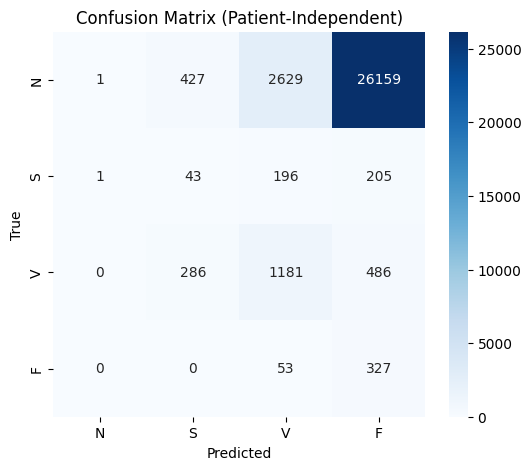

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["N","S","V","F"],
            yticklabels=["N","S","V","F"],
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Patient-Independent)")
plt.show()

In [ ]:
from sklearn.metrics import f1_score

macro_f1 = f1_score(y_test, y_pred, average='macro')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

print("Macro F1:", macro_f1)
print("Weighted F1:", weighted_f1)

Macro F1: 0.12207224422552938
Weighted F1: 0.025322866191134965


In [ ]:
# 1. Call model first to build layers
_ = model.predict(X_test[:1])

# 2. Pick one sample
idx = 10
x_sample = X_test[idx:idx+1]
true_label = y_test[idx]
pred_label = y_pred[idx]

# 3. Check correct last Conv1D layer name
model.summary()  # look at conv layer names
layer_name = "conv1d_2"  # update according to summary

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 183, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 183, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 91, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 87, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 87, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 43, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 41, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 41, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 364,422 (1.39 MB)

 Trainable params: 363,972 (1.39 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 2 (12.00 B)

In [ ]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import matplotlib.pyplot as plt

# Flatten 1D ECG for LIME (each timepoint = feature)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)

# Create a LIME explainer
explainer = LimeTabularExplainer(
    X_train_flat,
    mode='classification',
    training_labels=y_train,
    feature_names=[f"f{i}" for i in range(WINDOW)],
    class_names=["N", "A", "V", "F"],
    discretize_continuous=False
)

# Pick one test sample
idx = 10
x_sample_flat = X_test_flat[idx:idx+1]
true_label = y_test[idx]
pred_label = y_pred[idx]

# Define a wrapper predict function for LIME to reshape input
def lime_predict_fn(x):
    # LIME passes a 2D array (num_samples, num_features)
    # Our model expects (num_samples, num_features, 1)
    x_reshaped = x.reshape(-1, WINDOW, 1)
    return model.predict(x_reshaped)

# Explain the prediction using the wrapper predict function
exp = explainer.explain_instance(
    x_sample_flat[0],
    lime_predict_fn,
    num_features=WINDOW
)

# Get weights per feature (timepoint)
feature_weights = np.zeros(WINDOW)
for i, weight in exp.as_list():
    # i is like 'f12', extract index
    idx = int(i[1:])
    feature_weights[idx] = weight

# Plot ECG with LIME importance
signal = X_test[idx].squeeze()
plt.figure(figsize=(12,4))
plt.plot(signal, label="ECG Signal")
plt.plot(feature_weights * np.max(signal), label="LIME Importance", color='orange')
plt.legend()
plt.title(f"LIME Explanation (True={true_label}, Pred={pred_label})")
plt.show()

ModuleNotFoundError: No module named 'lime'